In [10]:
!pip freeze > ../requirements.txt

In [11]:
import os
import json
import torch
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from ultralytics import YOLO
from tqdm import tqdm


In [48]:
import os
import cv2
from ultralytics import YOLO

# YOLO 모델 로드 (얼굴 검출에 적합한 모델로 교체 가능)
model = YOLO("yolov8n.pt")

def process_image(image_path, conf_threshold=0.5):
    image = cv2.imread(image_path)
    if image is None:
        print("Error reading image:", image_path)
        return None
    results = model(image)
    # 첫 번째 결과 객체 사용
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()
    valid_indices = [i for i, c in enumerate(confs) if c >= conf_threshold]
    if not valid_indices:
        print("No face detected above threshold in:", image_path)
        return None
    # 가장 높은 confidence를 가진 검출 결과 선택
    best_idx = valid_indices[0]
    for i in valid_indices:
        if confs[i] > confs[best_idx]:
            best_idx = i
    box = boxes[best_idx]
    x1, y1, x2, y2 = map(int, box)
    face_crop = image[y1:y2, x1:x2]
    return face_crop

# 원본 이미지가 저장된 폴더 지정
original_dir = "../data2/validation/original"

# 지원되는 확장자
supported_ext = (".png", ".jpg", ".jpeg")

for filename in os.listdir(original_dir):
    if filename.lower().endswith(supported_ext):
        orig_path = os.path.join(original_dir, filename)
        processed_img = process_image(orig_path, conf_threshold=0.5)
        if processed_img is not None:
            # 처리된 이미지를 원본 파일 경로에 덮어쓰기 (원본 이미지를 대체)
            cv2.imwrite(orig_path, processed_img)
            #print(f"Processed and overwritten: {filename}")
        else:
            print(f"Skipping (no detection): {filename}")



0: 640x544 1 person, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 person, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 snowboard, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
No face detected above threshold in: ../data2/validation/original/0921_1971_06_00000051_F.png
Skipping (no detection): 0921_1971_06_00000051_F.png

0: 640x480 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 1 person, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 2 persons, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 1 person, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.0ms postprocess per

KeyboardInterrupt: 

In [12]:
def get_age_group(age):
    # 0: 0~10, 1: 10~20, 2: 20~30, 3: 30~40, 4: 40~50, 5: 50세 이상
    if age < 10:
        return 0
    elif age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 40:
        return 3
    elif age < 50:
        return 4
    else:
        return 5

class JSONFacesDataset(Dataset):
    def __init__(self, json_path, images_folder, transform=None):
        self.data = []
        self.transform = transform
        self.images_folder = images_folder
        if os.path.isdir(json_path):
            json_files = sorted([os.path.join(json_path, f) for f in os.listdir(json_path) if f.endswith('.json')])
            for jf in json_files:
                try:
                    with open(jf, 'r', encoding='cp1252', errors='replace') as f:
                        content = f.read().strip()
                        if not content:
                            continue
                        annotation = json.loads(content)
                except json.JSONDecodeError:
                    continue
                # "age_past"가 없으면 해당 샘플은 건너뜁니다.
                if "age_past" not in annotation:
                    continue
                if "filename" not in annotation:
                    annotation["filename"] = os.path.splitext(os.path.basename(jf))[0]
                file_format = annotation.get("format", "png").lower()
                image_file = f"{annotation['filename']}.{file_format}"
                image_path = os.path.join(self.images_folder, image_file)
                if not os.path.exists(image_path):
                    continue
                self.data.append(annotation)
        else:
            try:
                with open(json_path, 'r', encoding='cp1252', errors='replace') as f:
                    content = f.read().strip()
                    if content:
                        self.data = json.loads(content)
                    else:
                        self.data = []
            except json.JSONDecodeError:
                self.data = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        filename = entry["filename"]
        age = entry["age_past"]
        age_group = get_age_group(int(age))
        gender_str = entry["gender"]
        gender = 1 if gender_str.lower() == "male" else 0
        file_format = entry.get("format", "png").lower()
        image_file = f"{filename}.{file_format}"
        image_path = os.path.join(self.images_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, age_group, gender


In [13]:
import os
import json
from collections import Counter

# JSON 어노테이션이 저장된 디렉토리와 원본 이미지가 저장된 디렉토리 경로 (환경에 맞게 수정)
json_dir = "../data2/labeling"
images_folder = "../data2/original"

missing_files = []
total_files = 0

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(json_dir, filename)
        with open(json_path, 'r', encoding='cp1252', errors='replace') as f:
            try:
                annotation = json.load(f)
            except json.JSONDecodeError:
                print(f"JSON decode error in {json_path}, skipping.")
                continue
        
        # JSON 파일 내에 "filename" 키가 있으면 사용, 없으면 JSON 파일명(확장자 제거)을 사용
        if "filename" in annotation:
            base_filename = annotation["filename"]
        else:
            base_filename = os.path.splitext(filename)[0]
        
        # base_filename에 이미 확장자가 포함되어 있으면 그대로 사용, 없으면 annotation의 format(없으면 png)을 붙임
        ext = os.path.splitext(base_filename)[1]
        if ext:
            expected_image = base_filename
        else:
            file_format = annotation.get("format", "png").lower()
            expected_image = f"{base_filename}.{file_format}"
        
        image_path = os.path.join(images_folder, expected_image)
        
        total_files += 1
        if not os.path.exists(image_path):
            # case-insensitive 체크: 폴더 내 모든 파일명을 소문자로 변환하여 비교
            folder_files = os.listdir(images_folder)
            match = [f for f in folder_files if f.lower() == expected_image.lower()]
            if not match:
                missing_files.append(expected_image)

print(f"Total JSON files processed: {total_files}")
if missing_files:
    print(f"Missing image files ({len(missing_files)}):")
    for mf in missing_files:
        print(mf)
else:
    print("All expected image files exist.")

# 접두사(앞의 4자리 숫자)별 누락 개수 계산
prefix_counter = Counter(mf[:4] for mf in missing_files)

print("Missing image files grouped by prefix:")
for prefix, count in sorted(prefix_counter.items()):
    print(f"{prefix}: {count} missing files")


Total JSON files processed: 40150
All expected image files exist.
Missing image files grouped by prefix:


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_json = "../data2/labeling"
train_images_folder = "../data2/original"
val_json = "../data2/validation/labeling"
val_images_folder = "../data2/validation/original"

train_dataset = JSONFacesDataset(train_json, train_images_folder, transform=transform)
val_dataset = JSONFacesDataset(val_json, val_images_folder, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


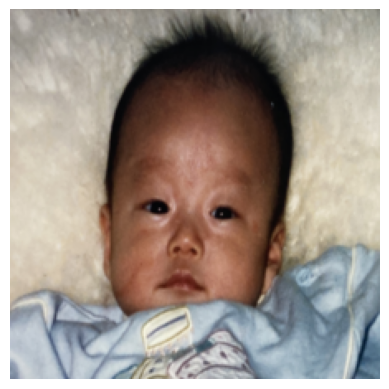

Age Group: 0~10 Gender: Male


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_tensor(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

group_names = {0: "0~10", 1: "10~20", 2: "20~30", 3: "30~40", 4: "40~50", 5: "50 이상"}

valid_sample = None
for i in range(len(train_dataset)):
    try:
        sample = train_dataset[i]
        valid_sample = sample
        break
    except FileNotFoundError as e:
        print(e)
        continue

if valid_sample is None:
    print("No valid sample found.")
else:
    image, age_group, gender = valid_sample
    imshow_tensor(image)
    print("Age Group:", group_names[age_group], "Gender:", "Male" if gender == 1 else "Female")


In [19]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.nn as nn
import torchvision.models as models
import torch
import torch.optim as optim

# 패치: check_hash 인자를 제거하여 해시 오류를 피함
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# 패치 적용 후, 두 가지 방식으로 모델 생성 테스트 (실행만 해도 패치가 적용됨)
efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_gender_classes=2, num_age_groups=6):
        super(MultiTaskEfficientNet, self).__init__()
        # EfficientNet-B0 최신 가중치 사용 (DEFAULT를 사용함)
        weights = EfficientNet_B0_Weights.DEFAULT
        self.backbone = models.efficientnet_b0(weights=weights)
        # EfficientNet의 classifier를 제거하여 특징 추출 부분만 사용
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        # 성별 분류 헤드
        self.gender_head = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_gender_classes)
        )
        # 나이 그룹 분류 헤드
        self.age_head = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_age_groups)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        gender_logits = self.gender_head(features)
        age_logits = self.age_head(features)
        return gender_logits, age_logits

# 모델 생성 및 GPU로 이동
model = MultiTaskEfficientNet(num_gender_classes=2, num_age_groups=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100.0%


In [20]:
import torch
from tqdm import tqdm

num_epochs = 10
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_train_samples = len(train_loader.dataset)
    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    for images, age_groups, genders in pbar_train:
        images = images.to(device, non_blocking=True)
        genders = genders.to(device, non_blocking=True)
        age_groups = age_groups.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        gender_logits, age_logits = model(images)
        loss_gender = criterion(gender_logits, genders)
        loss_age = criterion(age_logits, age_groups)
        loss = loss_gender + loss_age
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        pbar_train.set_postfix(loss=loss.item())
    avg_train_loss = train_loss / num_train_samples
    
    model.eval()
    val_loss = 0.0
    correct_gender = 0
    correct_age = 0
    total = 0
    
    # 각 나이 그룹별 정확도 집계를 위한 딕셔너리 (0~5 그룹)
    age_group_correct = {i: 0 for i in range(6)}
    age_group_total = {i: 0 for i in range(6)}
    
    num_val_samples = len(val_loader.dataset)
    pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
    with torch.no_grad():
        for images, age_groups, genders in pbar_val:
            images = images.to(device, non_blocking=True)
            genders = genders.to(device, non_blocking=True)
            age_groups = age_groups.to(device, non_blocking=True)
            gender_logits, age_logits = model(images)
            
            loss_gender = criterion(gender_logits, genders)
            loss_age = criterion(age_logits, age_groups)
            loss = loss_gender + loss_age
            val_loss += loss.item() * images.size(0)
            
            _, pred_gender = torch.max(gender_logits, 1)
            _, pred_age = torch.max(age_logits, 1)
            correct_gender += (pred_gender == genders).sum().item()
            correct_age += (pred_age == age_groups).sum().item()
            total += images.size(0)
            
            # 각 샘플별 나이 그룹 정확도 집계
            for true, pred in zip(age_groups.cpu().numpy(), pred_age.cpu().numpy()):
                age_group_total[true] += 1
                if true == pred:
                    age_group_correct[true] += 1
                    
            pbar_val.set_postfix(loss=loss.item())
    
    avg_val_loss = val_loss / num_val_samples
    gender_acc = correct_gender / total
    age_acc = correct_age / total
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Gender Acc: {gender_acc:.4f}, Age Group Acc: {age_acc:.4f}")
    
    # 각 나이 그룹별 정확도 출력
    print("Per Age Group Accuracy:")
    for group in range(6):
        if age_group_total[group] > 0:
            group_acc = age_group_correct[group] / age_group_total[group]
            print(f"Group {group}: {group_acc:.4f} ({age_group_total[group]} samples)")
        else:
            print(f"Group {group}: No samples")
    
    # Early Stopping: 검증 손실이 개선되지 않으면 학습 종료
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Validation loss did not improve for {patience} consecutive epochs. Early stopping.")
            break


Epoch 1/10 - Train Loss: 2.2137, Val Loss: 1.8862, Gender Acc: 0.8296, Age Group Acc: 0.3902
Per Age Group Accuracy:
Group 0: 0.6511 (943 samples)
Group 1: 0.6631 (1315 samples)
Group 2: 0.3076 (1193 samples)
Group 3: 0.0016 (624 samples)
Group 4: 0.0021 (486 samples)
Group 5: 0.0753 (239 samples)


Epoch 2/10 - Train Loss: 1.7472, Val Loss: 1.5855, Gender Acc: 0.8704, Age Group Acc: 0.4540
Per Age Group Accuracy:
Group 0: 0.7603 (943 samples)
Group 1: 0.6319 (1315 samples)
Group 2: 0.4912 (1193 samples)
Group 3: 0.0080 (624 samples)
Group 4: 0.0000 (486 samples)
Group 5: 0.1674 (239 samples)


Epoch 3/10 - Train Loss: 1.5379, Val Loss: 1.4670, Gender Acc: 0.8848, Age Group Acc: 0.4917
Per Age Group Accuracy:
Group 0: 0.7656 (943 samples)
Group 1: 0.6441 (1315 samples)
Group 2: 0.4937 (1193 samples)
Group 3: 0.1715 (624 samples)
Group 4: 0.0000 (486 samples)
Group 5: 0.3975 (239 samples)


Epoch 4/10 - Train Loss: 1.4287, Val Loss: 1.4078, Gender Acc: 0.8896, Age Group Acc: 0.5031
Per Age Group Accuracy:
Group 0: 0.7731 (943 samples)
Group 1: 0.6548 (1315 samples)
Group 2: 0.4493 (1193 samples)
Group 3: 0.2853 (624 samples)
Group 4: 0.0000 (486 samples)
Group 5: 0.4644 (239 samples)


Epoch 5/10 - Train Loss: 1.3540, Val Loss: 1.3734, Gender Acc: 0.8954, Age Group Acc: 0.5183
Per Age Group Accuracy:
Group 0: 0.7922 (943 samples)
Group 1: 0.6411 (1315 samples)
Group 2: 0.4979 (1193 samples)
Group 3: 0.2564 (624 samples)
Group 4: 0.0041 (486 samples)
Group 5: 0.5941 (239 samples)


Epoch 6/10 - Train Loss: 1.3004, Val Loss: 1.3415, Gender Acc: 0.9004, Age Group Acc: 0.5283
Per Age Group Accuracy:
Group 0: 0.7932 (943 samples)
Group 1: 0.6563 (1315 samples)
Group 2: 0.4962 (1193 samples)
Group 3: 0.2997 (624 samples)
Group 4: 0.0103 (486 samples)
Group 5: 0.5900 (239 samples)


Epoch 7/10 - Train Loss: 1.2544, Val Loss: 1.3189, Gender Acc: 0.9029, Age Group Acc: 0.5356
Per Age Group Accuracy:
Group 0: 0.7953 (943 samples)
Group 1: 0.6441 (1315 samples)
Group 2: 0.5189 (1193 samples)
Group 3: 0.3253 (624 samples)
Group 4: 0.0206 (486 samples)
Group 5: 0.5941 (239 samples)


Epoch 8/10 - Train Loss: 1.2146, Val Loss: 1.3031, Gender Acc: 0.9058, Age Group Acc: 0.5398
Per Age Group Accuracy:
Group 0: 0.8091 (943 samples)
Group 1: 0.6395 (1315 samples)
Group 2: 0.5189 (1193 samples)
Group 3: 0.3237 (624 samples)
Group 4: 0.0412 (486 samples)
Group 5: 0.6109 (239 samples)


KeyboardInterrupt: 

In [43]:
def predict(image_path, yolo_model, classification_model, transform, device):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = yolo_model(image)
    detections = []
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        confs = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()
        for box, conf, cls in zip(boxes, confs, class_ids):
            detections.append(np.concatenate([box, [conf, cls]]))
    face_crops = []
    for det in detections:
        if det[4] >= 0.5:
            x1, y1, x2, y2 = map(int, det[:4])
            crop = image_rgb[y1:y2, x1:x2]
            face_crops.append(Image.fromarray(crop))
    predictions = []
    classification_model.eval()
    with torch.no_grad():
        for crop in face_crops:
            crop_transformed = transform(crop).unsqueeze(0).to(device)
            gender_logits, age_logits = classification_model(crop_transformed)
            _, pred_gender = torch.max(gender_logits, 1)
            _, pred_age = torch.max(age_logits, 1)
            group_names = {0: "0~10", 1: "10~20", 2: "20~30", 3: "30~40", 4: "40~50", 5: "50 이상"}
            predictions.append({
                "gender": "Male" if pred_gender.item() == 1 else "Female",
                "age_group": group_names[pred_age.item()]
            })
    return predictions

# 예시 테스트 이미지 경로 (실제 경로로 수정)
yolo_model = YOLO("yolov8n.pt")
test_image_path = "../data2/validation/original/0991_2002_08_00000047_F.png"
preds = predict(test_image_path, yolo_model, model, transform, device)
print("Predictions:", preds)



0: 640x288 1 person, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)
Predictions: [{'gender': 'Female', 'age_group': '0~10'}]
